# <u> 2014-2015 NBA Shot Logs Final Project </u>
## By Rita Kho

In [1]:

import xlrd
import numpy as np
import pandas as pd
import seaborn as sns
%pylab inline



Populating the interactive namespace from numpy and matplotlib


# <u> 1. Data Set Description <u>

<ul>
<li> <b> df </b>is a dataset of all basketball shots made in 2014-2015 NBA season. Each row is a shot taken during the season. </li>
<li> <b> players</b> is a dataset of all players during the 2014-2015 season and their background information. Each row is a player.</li>
<li> <b> df2 </b> is the merged dataset between <b> df </b> and <b> players </b>.
</ul>

Important columns in <b> df </b> are:
<ol>
<li> LOCATION: If the game was away or home. </li>
<li> W or L: If the game resulted in a win or loss. </li>
<li> FINAL_MARGIN: The amount of points away from taking the lead when the shot was attempted. </li>
<li> PERIOD: The quarter the shot attempt was made. There are 4 quarters, 5 to 7 are overtime </li>
<li> GAME_CLOCK: Time left in the game. There are 12 minutes per quarter and the clock ticks down to the end of the quarter. End of quarter is 0 second. </li>
<li>SHOT_CLOCK: The time left for the offensive team to shoot. The offensive team is given 24 seconds to attempt a field goal. </li>
<li> DRIBBLES: Number of dribbles player make before taking a shot. </li>
<li> TOUCH_TIME: How long in seconds the shooting player touched the ball before attempting a shot. </li>
<li> SHOT_DIST: Distance of a shot in feet. </li>
<li> PTS_TYPE: The type of field goal attempted. 2 or 3 point shots.
<li> CLOSE_DEF_DIST: How far away the defener is when shot was attempted in feet. </li>
<li> FGM: Field goals made. 1 if shot is made, 0 is missed. </li>


</ol>

Important columns in <b> players </b> are:
<ol>
<li> Age: Age of player </li>
<li> Experience: Years of experience the player has in the NBA. R stands for rookie, first year. </li>
<li> First_Name: First name of shooter </li>
<li> Pos: Position of the player. There are 5 positions: Point Guard (PG), Shooting Guard (SG), Center (C), Power Foward (PF), Small Forward (SF) </li>
<li> Surname: Last name of shooter </li>


</ol>

In [2]:
df = pd.read_excel('shot_logs.xlsx')
players=pd.read_excel('players.xlsx')

In [5]:
df.head(1)

,GAME_ID,MATCHUP,LOCATION,W or L,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,01:09:00,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148


In [6]:
players.head(1)

,Age,Birth_Place,Birthdate,Collage,Experience,First_Name,Height,Pos,Surname,Team,Weight,BMI
0,33,mk,1982-07-29,NaN,1,Pero,207.5,PF,Antic,ATL,117.0,27.173755


# <u> 2. Data Preparation </u>

Concatenated the first and last names of the players in <b> players </b> dataset, lowercased it, and removed punctuation marks to clean it for the merge.

In [7]:
players['Name']=players.First_Name+ ' ' +players.Surname
players['Name']=players['Name'].str.lower()
players['Name']=players['Name'].str.replace('.','')

Occasionally players are traded to another team during a season. When this happens, most likely they will keep the same positions. In rare instances, the players will have to change positions. In <b> players</b> dataset, only 4 players changed positions during the season. Most of them changed between PG and SG, which are the similar guard positions. This is insignificant so I will only keep the first instance of the players names. 

In [8]:
players.groupby('Name')['Pos'].nunique().nlargest(5)

Name
austin rivers       2
brandon knight      2
goran dragic        2
quincy pondexter    2
aaron brooks        1
Name: Pos, dtype: int64

In [9]:
players.ix[(players.Name=='austin rivers') | (players.Name=='brandon knight') | (players.Name=='goran dragic') | (players.Name=='quincy pondexter'),'Pos']

204    PG
233    SG
245    PG
262    PG
299    SF
300    SG
368    SG
373    SG
Name: Pos, dtype: object

In [10]:
players.drop_duplicates(subset='Name', keep='first',inplace=True)

Merged <b> df </b> with <b> players </b> by the player's name. 

In [11]:
df2=df.merge(players,left_on='player_name', right_on='Name', how='left')
len(df2)

128069

Removed rows that are unnecessary for the analysis and those that are repeated information.

In [12]:
df2.drop(['GAME_ID','MATCHUP','SHOT_NUMBER','SHOT_RESULT','CLOSEST_DEFENDER_PLAYER_ID','PTS','player_name','player_id','Birthdate','Collage','First_Name','Surname','BMI'], axis=1,inplace=True)

Since GAME_CLOCK column is a date time string, converted it into integer in seconds. There are 12 minutes per quarter, or 720 seconds. The Excel data has it in hour and minute; should be minute and seconds.

In [13]:
#need to convert game_clock to numeric seconds since it's being read as a string/date_time. excel has it as HH:MM
def to_integer(dt_time):
    return 60*dt_time.hour+ 1*dt_time.minute

In [14]:
df2['GAME_CLOCK']=df2['GAME_CLOCK'].apply(to_integer)

Added columns to differentiate rookies and foreigners based on years of experience (less than 1 year is a rookie) and those born outside of U.S. are considered foreigners. 

Also added clutch factor column. Clutch factor are shots made last 2 minutes of the last quarter when the points between the teams are 5 points or less. 

In [15]:
df2['rookie']=( (df2.Experience<=1) | (df2.Experience=='R'))*1.0
df2['clutchfactor']= ((df2.PERIOD==4) & (df2.FINAL_MARGIN<=5) & (df2.GAME_CLOCK<=120))*1.0
df2['clutch_made']= ((df2.PERIOD==4) & (df2.FINAL_MARGIN<=5) & (df2.GAME_CLOCK<=120) &(df2.FGM==1))*1.0
df2['foreigner']= (df2.Birth_Place!='us')*1.0

After creating rookie and foreigner column, decided to drop these.

In [16]:
df2.drop(['Experience', 'Birth_Place'],axis=1, inplace=True)

SHOT_CLOCK is the only colummn with NAN. If there is no data for shot clock, it means it is the last possession of the game and game time has run out (game clock =0). Thus, shot clock should be 0.

In [17]:
pd.isnull(df2).sum() > 0

LOCATION            False
W or L              False
FINAL_MARGIN        False
PERIOD              False
GAME_CLOCK          False
SHOT_CLOCK           True
DRIBBLES            False
TOUCH_TIME          False
SHOT_DIST           False
PTS_TYPE            False
CLOSEST_DEFENDER    False
CLOSE_DEF_DIST      False
FGM                 False
Age                 False
Height              False
Pos                 False
Team                False
Weight              False
Name                False
rookie              False
clutchfactor        False
clutch_made         False
foreigner           False
dtype: bool

In [18]:
df2.replace(np.NAN,0,inplace=True)

# <u> 3. Interesting Finding Summary </u>

During the last two minutes of the quarter, point guards tend to have more touch time with the ball and attempt more field goals than any other positions and time in the game. Also, compared to other quarters they tend to make more field goal attempts during this time, especially 3 pointers.

<i> Background: Point guards are one of five positions in basketball and are known as the team leader  on the court. They  control the ball and run the team's offensive plays, hence they have more ball handling and control the tempo of the game. They provide scoring opportunities for their team through passing the ball as they deem fit. </i>


# <u> 4. Machine Learning: Clustering </u>

After several attempts on using decision tree and regression, they did not result in any findings. Clustering worked in this case. Through clustering, I was able to detect two different groups and research further into the differences between them.

In [19]:
cluster= pd.get_dummies(df2,columns=['Pos', 'PTS_TYPE'])

In [20]:
clusters=cluster.drop(['Name', 'CLOSEST_DEFENDER', 'Team', 'clutch_made', 'Age', 'W or L', 'Weight','SHOT_DIST','LOCATION','PERIOD', 'rookie', 'DRIBBLES', 'foreigner'],axis=1)

In [21]:
from sklearn.cluster import KMeans
clu = KMeans(n_clusters=2, random_state=0)
clu.fit(clusters)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [22]:
clusters['cluster'] = clu.labels_

In [23]:
clusterz=clusters.groupby('cluster').mean()

In [24]:
clusterz

,FINAL_MARGIN,GAME_CLOCK,SHOT_CLOCK,TOUCH_TIME,CLOSE_DEF_DIST,FGM,Height,clutchfactor,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG,PTS_TYPE_2,PTS_TYPE_3
cluster,,,,,,,,,,,,,,,
0,0.185406,170.861966,11.441826,3.004492,4.100946,0.448948,197.035860,0.060164,0.144768,0.207553,0.258535,0.160150,0.228994,0.720463,0.279537
1,0.231805,530.099580,12.377443,2.529723,4.144860,0.455298,198.030946,0.000000,0.172918,0.227408,0.222638,0.162228,0.214807,0.750047,0.249953


These are some of the difference after analyzing the above table: cluster 0 has less time in the game clock with sightly more touch time and PG. Because of this table, I started to analyze further if PG have some correlation with the amount of time they have the ball towards the end of the game.

In [25]:
import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

In [26]:
X= clusters.drop(['cluster','clutchfactor','SHOT_CLOCK','GAME_CLOCK'], axis=1)
Y=clusters.cluster

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=2)

In [28]:
dt = tree.DecisionTreeClassifier(max_depth=2)
dt.fit(X=X,y=Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

The below tree is not the best tree, but it does demonstrate that:
<ol>
<li> If touch time less than 10 seconds and if height is smaller than 195cm, most likely in cluster 0 (PG are usually shorter). </li>
<li> If touch time less than 10 seconds but height is larger than 195cm, most likely in cluster 1 (slightly more chance of being C who are taller players).</li>
<li> If touch time greater than 10 seconds, most likely in cluster 0.

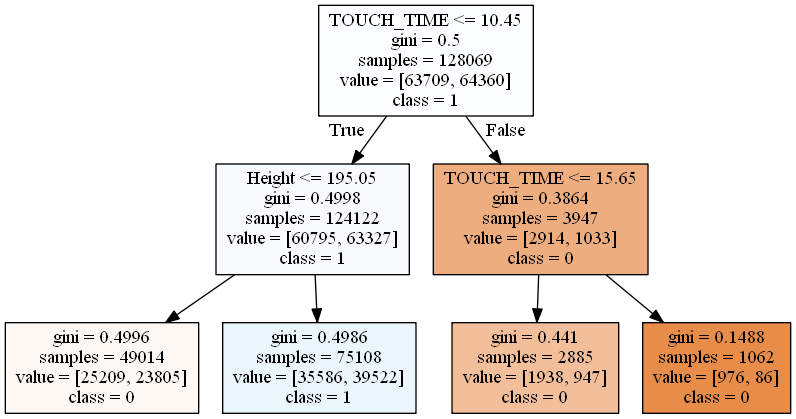

In [29]:
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

As shown below, PG is positively correlated with touch time.

In [30]:
clusters.corr()

,FINAL_MARGIN,GAME_CLOCK,SHOT_CLOCK,TOUCH_TIME,CLOSE_DEF_DIST,FGM,Height,clutchfactor,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG,PTS_TYPE_2,PTS_TYPE_3,cluster
FINAL_MARGIN,1.000000,0.005975,-0.001961,0.010788,0.033064,0.058762,-0.024651,-0.090954,-0.017966,0.014883,0.011124,-0.015225,0.003062,-0.024134,0.024134,0.001753
GAME_CLOCK,0.005975,1.000000,0.108234,-0.103308,0.007455,0.011476,0.069139,-0.252867,0.046561,0.029927,-0.055355,0.003883,-0.017183,0.048474,-0.048474,0.865247
SHOT_CLOCK,-0.001961,0.108234,1.000000,-0.139159,0.022725,0.101981,0.005151,-0.043817,0.016739,-0.018862,-0.006049,0.008395,0.002793,0.056575,-0.056575,0.075669
TOUCH_TIME,0.010788,-0.103308,-0.139159,1.000000,-0.164737,-0.045299,-0.315760,0.025497,-0.145563,-0.165354,0.329166,-0.064603,0.010858,0.181007,-0.181007,-0.077992
CLOSE_DEF_DIST,0.033064,0.007455,0.022725,-0.164737,1.000000,-0.001074,-0.055468,-0.008419,-0.104625,0.011679,0.009791,0.048738,0.027259,-0.414198,0.414198,0.007966
FGM,0.058762,0.011476,0.101981,-0.045299,-0.001074,1.000000,0.048235,-0.013908,0.051669,0.020225,-0.025398,-0.015059,-0.026094,0.121293,-0.121293,0.006380
Height,-0.024651,0.069139,0.005151,-0.315760,-0.055468,0.048235,1.000000,-0.032907,0.532868,0.403877,-0.722426,0.123756,-0.236325,0.197850,-0.197850,0.054838
clutchfactor,-0.090954,-0.252867,-0.043817,0.025497,-0.008419,-0.013908,-0.032907,1.000000,-0.022702,-0.024414,0.023609,0.006249,0.014403,-0.046798,0.046798,-0.176544
Pos_C,-0.017966,0.046561,0.016739,-0.145563,-0.104625,0.051669,0.532868,-0.022702,1.000000,-0.229186,-0.244596,-0.190549,-0.232102,0.238606,-0.238606,0.038499
Pos_PF,0.014883,0.029927,-0.018862,-0.165354,0.011679,0.020225,0.403877,-0.024414,-0.229186,1.000000,-0.296699,-0.231138,-0.281542,0.090626,-0.090626,0.024063


Obvious finding: Center is positively correlated with height; these defenders are usually taller. Point guards are negatively correlated with height; they are usually smaller players with more speed.

# <u> 5. Validity of the Finding </u>

Below are table/charts to validate that PGs attempt more shots and have more touch time last 2 minutes of the game (keep in mind game clock is in seconds and 720 is beginning of quarter, 0 is end).

In [31]:
cluster2=df2.copy()

In [32]:
cluster2['gameclock']=pd.cut(cluster2.GAME_CLOCK,6) #breaking up the game clock into 6 buckets

In [33]:
cluster2['shot']=1

In [36]:
table=cluster2.groupby(by=['Pos','gameclock']).agg({'TOUCH_TIME':{'Average_Touch_Time': 'mean'}, 'shot': {'Total_Shot_Attempts':'sum'}})

In [37]:
table

TOUCH_TIME                shot
                 Average_Touch_Time Total_Shot_Attempts
Pos gameclock                                          
C   (-0.72, 120]           1.595212                2966
    (120, 240]             1.698140                3118
    (240, 360]             1.753821                3428
    (360, 480]             1.761148                3660
    (480, 600]             1.797719                3683
    (600, 720]             1.842293                3497
PF  (-0.72, 120]           1.705634                4597
    (120, 240]             1.808266                4488
    (240, 360]             1.838078                4538
    (360, 480]             1.822578                4779
    (480, 600]             1.872294                4768
    (600, 720]             1.818831                4689
PG  (-0.72, 120]           5.802774                6526
    (120, 240]             4.514459                5194
    (240, 360]             4.388906                5156
    (360, 480]             4.175469                5014
    (480, 600]             4.076778                4922
    (600, 720]             3.781118                3988
SF  (-0.72, 120]           2.647738                3492
    (120, 240]             2.345080                3394
    (240, 360]             2.312875                3635
    (360, 480]             2.271181                3581
    (480, 600]             2.208486                3488
    (600, 720]             2.092600                3054
SG  (-0.72, 120]           3.548803                5471
    (120, 240]             2.890462                4802
    (240, 360]             2.752580                4690
    (360, 480]             2.608111                4537
    (480, 600]             2.566796                4653
    (600, 720]             2.433114                4261

To validate more touch time for Point Guards during last two minutes <i> (remember game clock is in seconds, 720 is begining of quarter and 0 is the end).</i>

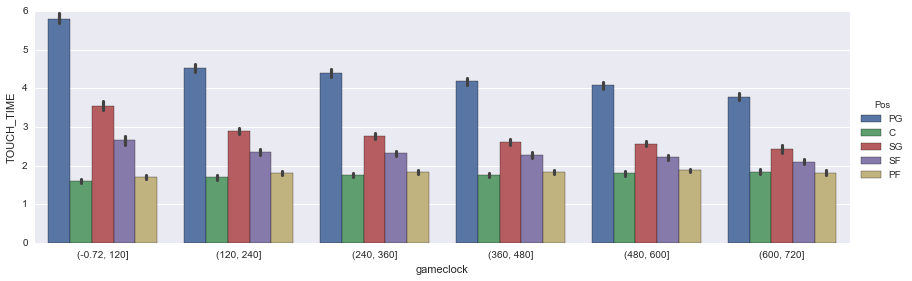

In [38]:
sns.factorplot(x='gameclock', y='TOUCH_TIME', hue='Pos',data=cluster2, kind='bar',aspect=3)

To validate more field goal attempts for point guards last 2 minutes.

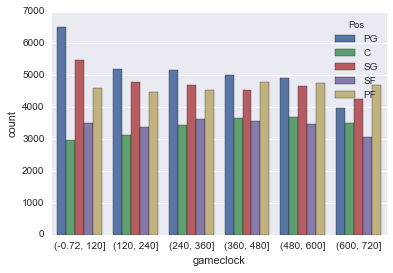

In [39]:
sns.countplot(x='gameclock',hue='Pos',data=cluster2)

To further validate that PGs have more touch time during last 2 minutes on 3 point shot attempts too!

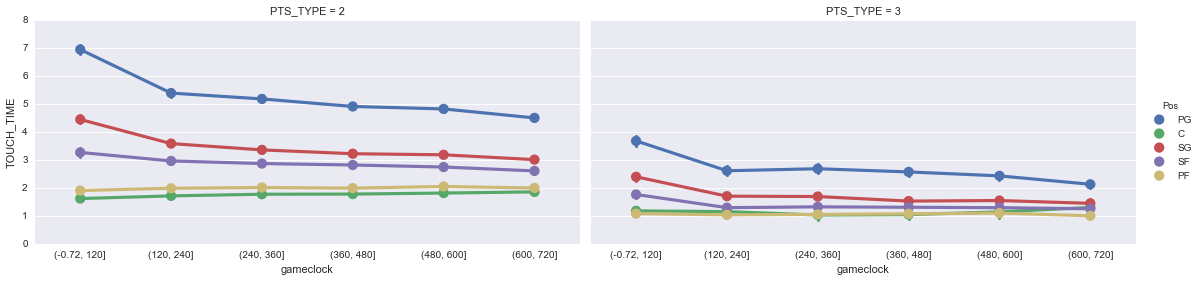

In [40]:
sns.factorplot(x='gameclock', y='TOUCH_TIME', col='PTS_TYPE', hue='Pos',data=cluster2, kind='point',aspect=2)

# <u> 6.  Managerial Insights</u>

During the last two minutes of the game, point guards have more time on the ball. There are a couple of speculations as to why this occurred: 
<ol> <li> There are probably more scripted plays during last two minutes (especially if there is a low margin to victory). Hence point guards are relied upon to carry out the team's plays to increase their lead. </li>
<li> The team is ahead so the point guards waste time to keep their lead. </li>
</ol>

This is a surprised finding as one may think historically shooting guards (e.g. Michael Jordan, Dwayne Wade, Kobe Bryant...) would handle the last couple minutes of the game. It appears that during this time in the NBA (2014-2015 season), we started to see that point guards and quick ball movement are becoming more prominent.

Therefore, from a defender perspective, place your best defender or double team against the opposing PG last couple minutes to prevent scoring. There are many factors to the game (who the PG is, the nature of the team, team rivalry, injuries, etc.) so it is best to plan ahead before a game and strategize how to defend the opposing team's PG.

# <u> 7. Extra Analysis In Case You're Interested</u>

## Highest Field Goal Percentage Including Dunks

Eliminate those who have less than 164 shot attempts made in the season (teams play around 82 games per season, assuming at least 2 shot attempts made per game).

In [41]:
df3=df2.groupby('Name').agg({'FGM': {'Total_Attempts': 'count','Made':'sum', 'FGM_Percentage': 'mean'}})
df4=df3['FGM']

In [42]:
all=df4.ix[df4.Total_Attempts>=164,:].sort_values(by='FGM_Percentage', ascending=False)
all.ix[0:10,:]

,Total_Attempts,Made,FGM_Percentage
Name,,,
deandre jordan,393,280,0.712468
tyson chandler,340,230,0.676471
rudy gobert,267,167,0.625468
james johnson,311,191,0.614148
ed davis,350,211,0.602857
alexis ajinca,211,126,0.597156
mason plumlee,403,236,0.585608
john henson,241,140,0.580913
amir johnson,402,233,0.579602


## Worst Field Goal Efficiencies

Elminated those with less than 164 shot attempts during the season.

In [43]:
all=df4.ix[df4.Total_Attempts>=164,:].sort_values(by='FGM_Percentage')
all.ix[0:10,:]

,Total_Attempts,Made,FGM_Percentage
Name,,,
ramon sessions,219,72,0.328767
vince carter,283,94,0.332155
nik stauskas,192,65,0.338542
nate robinson,202,69,0.341584
dante exum,285,98,0.343860
ronnie price,223,77,0.345291
kostas papanikolaou,187,65,0.347594
matthew dellavedova,210,73,0.347619
pero antic,222,79,0.355856


## Highest Field Goal Percentage (>=5 ft from basket)

Again, eliminating players with less than 164 shot attempts during the season.

In [44]:
shooters=df2.ix[df2.SHOT_DIST>=5,:]

In [45]:
topshooter=shooters.groupby('Name').agg({'FGM': {'Total_Attempts': 'count','Made':'sum', 'FGM_Percentage': 'mean'}})
topshooters=topshooter['FGM']
top=topshooters.ix[topshooters.Total_Attempts>=164,:].sort_values(by='FGM_Percentage', ascending=False)
top.ix[0:10,:]

,Total_Attempts,Made,FGM_Percentage
Name,,,
amir johnson,184,90,0.489130
kyle korver,463,224,0.483801
shaun livingston,194,93,0.479381
al horford,536,254,0.473881
chris paul,819,383,0.467643
jonas valanciunas,229,107,0.467249
nikola vucevic,609,284,0.466338
donatas motiejunas,409,190,0.464548
tyler zeller,210,97,0.461905


## Best 3 Point Shooter

I wanted to see the most frequent players, so eliminated those with less than 250 shot attempts.

In [46]:
three=df2.ix[df2.PTS_TYPE==3,:]

In [47]:
threes=three.groupby('Name').agg( { 'PTS_TYPE': {'Total_Attempts': 'count'}, 'FGM':{'Field_Goals_Made':'sum'}})

In [48]:
threes.columns=threes.columns.droplevel(0)

In [49]:
threes['FGM_Percentage']=threes.Field_Goals_Made/threes.Total_Attempts

In [50]:
threez=threes.ix[threes.Total_Attempts>=250]

In [51]:
threez.sort_values('FGM_Percentage', ascending=False).iloc[:10]

,Field_Goals_Made,Total_Attempts,FGM_Percentage
Name,,,
kyle korver,176,355,0.495775
klay thompson,177,407,0.434889
jj redick,140,329,0.425532
stephen curry,190,456,0.416667
kyrie irving,120,297,0.404040
brandon knight,119,300,0.396667
danny green,136,346,0.393064
wesley matthews,173,443,0.390519
channing frye,115,299,0.384615


## Most Points Per Attempt

In [52]:
ppa=df.merge(players,left_on='player_name', right_on='Name', how='left')

In [53]:
ppa2=ppa.groupby('Name', as_index=False).agg( {'PTS_TYPE':{'Total_Attempts': 'count'},'FGM':{'Field_Goal_Made': 'sum'}, 'PTS': {'Total_Points': 'sum'}, 'TOUCH_TIME': {'Avg_Touch_Time': 'mean'}, 'SHOT_DIST':{ 'Avg_Shot_Dist': 'mean'}})

In [54]:
ppa2.columns=ppa2.columns.droplevel(0)

In [55]:
ppa2['Pts_Per_Attempt']=ppa2.Total_Points/ppa2.Total_Attempts

In [56]:
ppa2.rename(columns = {'':'Name'}, inplace = True)

Highest Points Per Attempt Excluding Players < 500 Attempts because want to include only star players. These players contribute more to the game point wise.

In [57]:
ppa3=ppa2.ix[ppa2.Total_Attempts>=500,:].sort_values(by='Pts_Per_Attempt', ascending=False)

In [58]:
ppa3.iloc[0:10,:]

,Name,Field_Goal_Made,Total_Attempts,Total_Points,Avg_Shot_Dist,Avg_Touch_Time,Pts_Per_Attempt
247,stephen curry,470,968,1130,17.470455,3.911983,1.167355
128,jj redick,299,649,738,19.503698,1.423729,1.137134
276,wesley matthews,336,748,845,18.522193,2.124465,1.129679
157,klay thompson,449,971,1075,16.790628,2.321730,1.107106
94,goran dragic,378,753,828,11.740106,3.226959,1.099602
60,danny green,237,556,610,18.790108,1.463489,1.097122
3,al horford,387,715,783,11.973566,1.809231,1.095105
179,marcin gortat,311,570,622,7.375614,1.672105,1.091228
71,derrick favors,369,677,738,7.729394,1.705465,1.090103
19,anthony davis,457,841,915,10.406540,1.880499,1.087990


In [59]:
ppa3.Pts_Per_Attempt.mean()

0.99266143927373429

To see average points per attempt per player and to visualize that the mean is around 1.

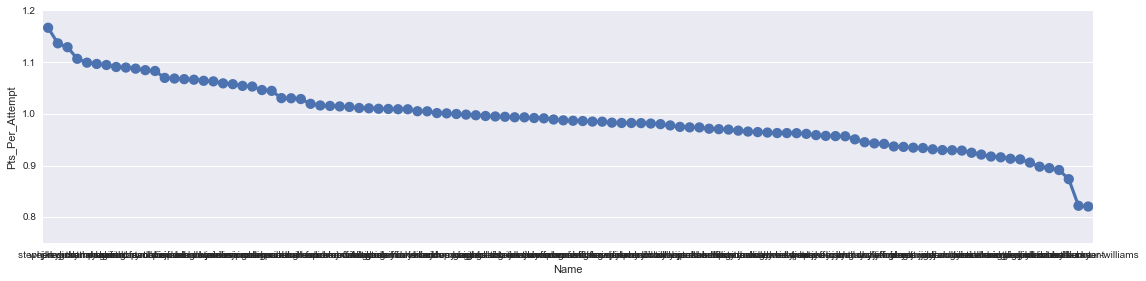

In [60]:
sns.factorplot(x='Name', y='Pts_Per_Attempt', data=ppa3, kind='point',aspect=4)

## Best Defenders

In [61]:
defender=ppa.groupby('CLOSEST_DEFENDER').agg({'PTS_TYPE':{'Total_Attempts_Against': 'count'}, 'FGM': {'Made_Shots_Against':'sum'}, 'CLOSE_DEF_DIST': {'Defender_Distance': 'mean'}})

In [62]:
defender.columns=defender.columns.droplevel(0)

In [63]:
defender=defender.ix[defender.Total_Attempts_Against>=500,:]

In [64]:
defender['made_shots_perc']=defender.Made_Shots_Against/defender.Total_Attempts_Against

In [65]:
defenders=defender.sort_values('made_shots_perc')

I am not sure if this dataset is the best to analyze defenders. It is surprising to see some of the players on this list.

In [66]:
defenders.iloc[:10]

,Made_Shots_Against,Total_Attempts_Against,Defender_Distance,made_shots_perc
CLOSEST_DEFENDER,,,,
"Curry, Stephen",209,527,4.168501,0.396584
"Green, Draymond",301,751,3.790945,0.400799
"Ellis, Monta",226,563,4.453108,0.401421
"Davis, Anthony",247,609,3.947455,0.405583
"Hibbert, Roy",212,517,3.618762,0.410058
"Ibaka, Serge",334,814,4.070639,0.410319
"Batum, Nicolas",215,521,4.033589,0.412668
"Thompson, Klay",215,520,4.341154,0.413462
"Barnes, Matt",236,570,4.525965,0.414035


## Per Quarter Shot Analysis

4 quarters in NBA, 5th to 7th are overtime. Better FGM efficiency and shot attempts made first quarter, then decreases per quarter.

In [67]:
df2.groupby('PERIOD').agg( { 'FGM': ['count','sum','mean']})

FGM                 
        count    sum      mean
PERIOD                        
1       33961  15640  0.460528
2       31651  14278  0.451107
3       32211  14725  0.457142
4       29123  12817  0.440099
5         912    356  0.390351
6         168     73  0.434524
7          43     16  0.372093

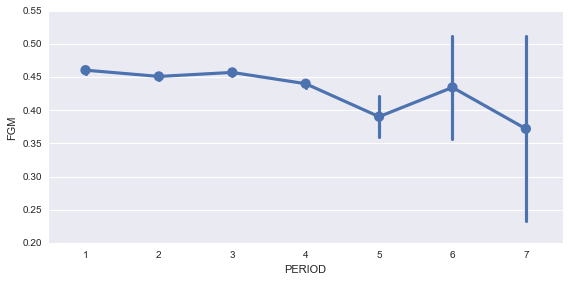

In [68]:
sns.factorplot(x='PERIOD', y='FGM', data=df2, kind='point', aspect=2)

## Clutch Shots

Rita's Definition of Clutch: Last 2 minutes of 4th quarter with margin to victory of 5 points or less.

Top 10 Most Made Clutch Shots by Player

In [69]:
clutch=df2.ix[ (df2.clutchfactor==1), :]
clutchs=clutch.groupby('Name').agg( {'FGM': {'Total_Attempts': 'count', 'Made':'sum', 'FGM_Percentage':'mean'}})
clutchz=clutchs['FGM'].sort_values(by='Made',ascending=False)
clutchz.ix[0:10,:]

,Total_Attempts,Made,FGM_Percentage
Name,,,
nikola vucevic,36,20,0.555556
carmelo anthony,45,20,0.444444
eric bledsoe,37,20,0.540541
james harden,39,19,0.487179
monta ellis,44,18,0.409091
markieff morris,29,18,0.620690
kentavious caldwell-pope,46,18,0.391304
gordon hayward,41,18,0.439024
brandon knight,46,17,0.369565


## Shots by Position

In [70]:
df2.groupby('Pos', as_index=False)['FGM'].mean()

,Pos,FGM
0,C,0.511301
1,PF,0.471230
2,PG,0.429675
3,SF,0.435042
4,SG,0.427817


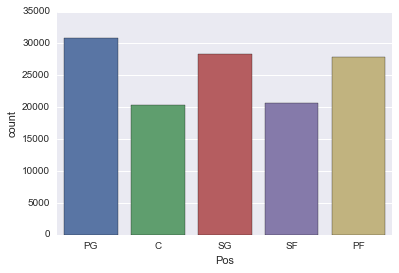

In [71]:
sns.countplot('Pos', data=df2)

## Top Rookies

I consider rookies as players in their first (R) or second (1) year.

In [72]:
newbs=ppa.ix[(ppa.Experience=='R') | (ppa.Experience==1),:]

In [73]:
newbs2=newbs.groupby('Name', as_index=False).agg( {'PTS_TYPE':{'Total_Attempts': 'count'},'FGM':{'Field_Goal_Made': 'sum'}, 'PTS': {'Total_Points': 'sum'}, 'TOUCH_TIME': {'Avg_Touch_Time': 'mean'}, 'SHOT_DIST':{ 'Avg_Shot_Dist': 'mean'}})

In [74]:
newbs2.columns=newbs2.columns.droplevel(0)

In [75]:
newbs2['Pts_Per_Attempt']=newbs2.Total_Points/newbs2.Total_Attempts

In [76]:
newbs2['Field_Goal_Percentage']=newbs2.Field_Goal_Made/newbs2.Total_Attempts

Decided to rank them by total attempts because that is correlated to how often they are off the bench.

In [77]:
newbs3=newbs2.sort_values('Total_Attempts', ascending=False)

In [78]:
newbs3.rename(columns = {'':'Name'}, inplace = True)

In [79]:
newbs3.iloc[0:5]

,Name,Field_Goal_Made,Total_Attempts,Total_Points,Avg_Shot_Dist,Avg_Touch_Time,Pts_Per_Attempt,Field_Goal_Percentage
4,andrew wiggins,348,797,730,12.123338,2.311543,0.915935,0.436637
47,trey burke,294,783,684,16.838953,3.352874,0.873563,0.375479
48,victor oladipo,328,729,710,11.751989,4.388477,0.973937,0.449931
24,kentavious caldwell-pope,272,683,659,17.168521,1.972182,0.964861,0.398243
30,michael carter-williams,253,657,539,12.312481,4.726027,0.820396,0.385084


Looks like Wiggins and Caldwell-Pope accelereated their career after their rookie season:
<ul>
<li> <b> Andrew Wiggins </b>: Won rookie of the year for 2014-2015 season. Continued playing in Timberwolves the following year with slightly more field goal attempts and increase FG % to 45%. One of the rising stars. </li>
<li><b> Trey Burke </b>: During his second season his FG % dropped in the same team. He then went to bench and barely started a game in 2016. Currently sitting on Wizards bench not doing so well.</li>
<li><b> Victor Oladipo </b>: Currently playing for OKC and doing pretty well.</li>
<li><b> Kentavious Caldwell-Pope </b>: Increased his stats the following year. Currently a starter for the Pistons so he's doing pretty well. </li>
<li><b> Michael Carter-Williams </b>: Went onto the Bucks the following year and the Bulls thereafter. He struggled with injuries a couple of times and struggled to come off the bench. </li>

## Best Team FGM Efficiency

In [80]:
bestteam=df2.groupby('Team').agg({'FGM':{'Total_Attempts':'count', 'FGM_Percentage': 'mean'}})

In [81]:
bestteam.columns=bestteam.columns.droplevel(0)

As predicted, Warriors have the highest field goal percentage. This was the year they won the championship.

In [82]:
bestteam.sort_values('FGM_Percentage', ascending=False).iloc[:10]

,Total_Attempts,FGM_Percentage
Team,,
GSW,4553,0.479244
LAC,4841,0.475728
WAS,4615,0.469556
NOH,3979,0.469465
ATL,4544,0.468310
MEM,4195,0.468176
CLE,5138,0.462631
TOR,4370,0.462471
DAL,4520,0.461062
